<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [3]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset
import torchvision.transforms as tfs
from torch.nn import functional as F
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image 
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small?resource=download-directory) и  [здесь](https://drive.google.com/drive/folders/14H7LQWzd09SaM11oLfGtd455sWH2rmRW?usp=share_link)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [13]:
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
image_size = 128
batch_size = 32
DATA_DIR = r'./faces_dataset_small'
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(DEVICE)

cuda


In [14]:
class MyDataset(Dataset):
    def __init__(self, image_paths, transform=None, label = None):
        self.image_paths = image_paths
        self.transform = transform
        self.all_imgs = os.listdir(image_paths)
        self.label = label
        
    def __getitem__(self, index):
        image_path = os.path.join(self.image_paths, self.all_imgs[index])
        x = Image.open(image_path).convert("RGB")
        if self.transform is not None:
            x = self.transform(x)
        return x, self.label
    
    def __len__(self):
        return len(self.all_imgs)


def get_dataloader(image_size, batch_size, train_dir):
    """
    Builds dataloader for training data.
    Use tt.Compose and tt.Resize for transformations
    :param image_size: height and wdith of the image
    :param batch_size: batch_size of the dataloader
    :returns: DataLoader object 
    """
    # TODO: resize images, convert them to tensors and build dataloader
    transform = tfs.Compose(
        [
            tfs.Resize(image_size),
            tfs.CenterCrop(image_size),
            tfs.ToTensor(),
            tfs.Normalize(*stats),
        ]
    )
    train_ds = MyDataset(image_paths=train_dir, transform = transform, label = 1)
    train_dl = DataLoader(train_ds, batch_size, shuffle=True, pin_memory=True, 
                          drop_last=True)
    return train_dl 

In [15]:
#TODO: build dataloader and transfer it to device
train_dl = get_dataloader(image_size, batch_size, DATA_DIR)


In [16]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]


def show_images(images, nmax=32):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))


def show_batch(dl, nmax=32):
    for images, _ in dl:
        show_images(images, nmax)
        break

In [17]:
next(iter(train_dl))[0].shape

torch.Size([32, 3, 128, 128])

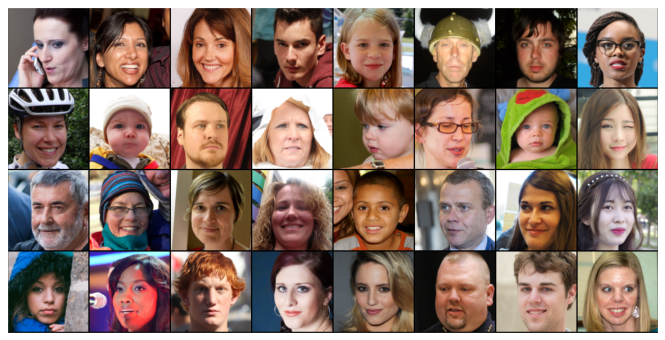

In [18]:
show_batch(train_dl)

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [31]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.cnn1 = nn.Sequential( 
            nn.Conv2d(3, 128, kernel_size=5, stride=2, padding=2, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.cnn2 = nn.Sequential( 
            nn.Conv2d(128, 128, kernel_size=5, stride=2, padding=2, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.cnn3 = nn.Sequential( 
            nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.cnn4 = nn.Sequential( 
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.cnn5 = nn.Sequential( 
            nn.Conv2d(512, 1, kernel_size=3, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.lin = nn.Linear(4*4, 1)

    def forward(self, x):
        # print(x.shape)
        x = self.cnn1(x)
        # print(x.shape)
        x = self.cnn2(x)
        # print(x.shape)
        x = self.cnn3(x)
        # print(x.shape)
        x = self.cnn4(x)
        # print(x.shape)
        x = self.cnn5(x)
        # print(x.shape)
        x = x.reshape(batch_size, -1)
        # print(x.shape)
        x = self.lin(x)
        # print(x.shape)
        x = F.sigmoid(x)

        return x
    

class Generator(nn.Module):
    def __init__(self, latent_size):
        super(Generator, self).__init__()

        self.cnn0 = nn.Sequential( 
            nn.ConvTranspose2d(32, 512, kernel_size=2, stride=2, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),  
        )
        self.cnn1 = nn.Sequential( 
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),  
        )
        self.cnn2 = nn.Sequential( 
            nn.ConvTranspose2d(256, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),  
        )
        self.cnn3 = nn.Sequential( 
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),  
        )
        self.cnn4 = nn.Sequential( 
            nn.ConvTranspose2d(128, 3, kernel_size=4, stride=2, padding=1, bias=False),
        )

    def forward(self, x):
        # print(x.shape)
        x = x.reshape(x.shape[0], -1, 4, 4)
        # print(x.shape)
        x = self.cnn0(x)
        # print(x.shape)
        x = self.cnn1(x)
        # print(x.shape)
        x = self.cnn2(x)
        # print(x.shape)
        x = self.cnn3(x)
        # print(x.shape)
        x = self.cnn4(x)
        # print(x.shape)
        x = F.tanh(x)

        return x

In [32]:
latent_size = 512 # choose latent size

generator = Generator(latent_size)
discriminator = Discriminator()

torch.Size([32, 3, 128, 128])


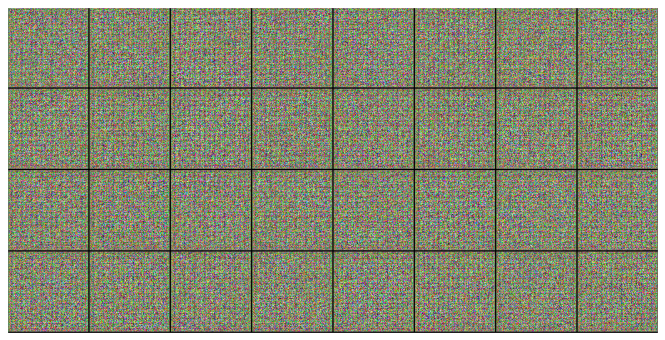

In [33]:
xb = torch.randn(batch_size, latent_size, 1, 1) 
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [34]:
model = {
    "discriminator": discriminator.to(DEVICE),
    "generator": generator.to(DEVICE),
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss(),
}

In [35]:
fixed_latent = torch.randn(batch_size, latent_size, 1, 1, device=DEVICE)

In [36]:
def fit(model, criterion, epochs, lr, start_idx=1):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }
    
    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(train_dl, leave=False):
            real_images = real_images.to(DEVICE)
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=DEVICE)
            # print(f'real_preds={real_preds.shape}\treal_targets={real_targets.shape}\treal_images={real_images.shape}')
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=DEVICE)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=DEVICE)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=DEVICE)
            fake_images = model["generator"](latent)
            
            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=DEVICE)
            loss_g = criterion["generator"](preds, targets)
            
            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())
            
        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
    
    return losses_g, losses_d, real_scores, fake_scores

In [37]:
torch.cuda.empty_cache()

lr = 0.0002
epochs = 30
history = fit(model, criterion, epochs, lr)

  0%|          | 0/98 [00:00<?, ?it/s]

Epoch [1/30], loss_g: 3.8665, loss_d: 0.3774, real_score: 0.8408, fake_score: 0.1356


  0%|          | 0/98 [00:00<?, ?it/s]

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

Text(0.5, 1.0, 'Losses')

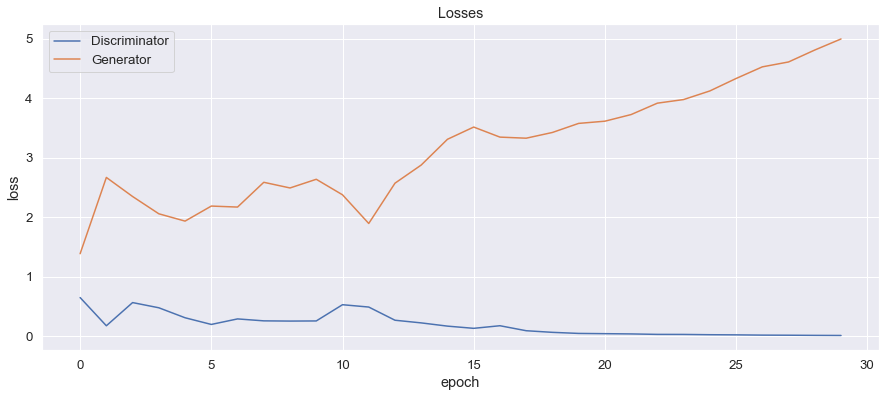

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses')

По графикам видно, что модель обучается

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [ ]:
n_images = 128

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=DEVICE)
fake_images = model["generator"](fixed_latent)

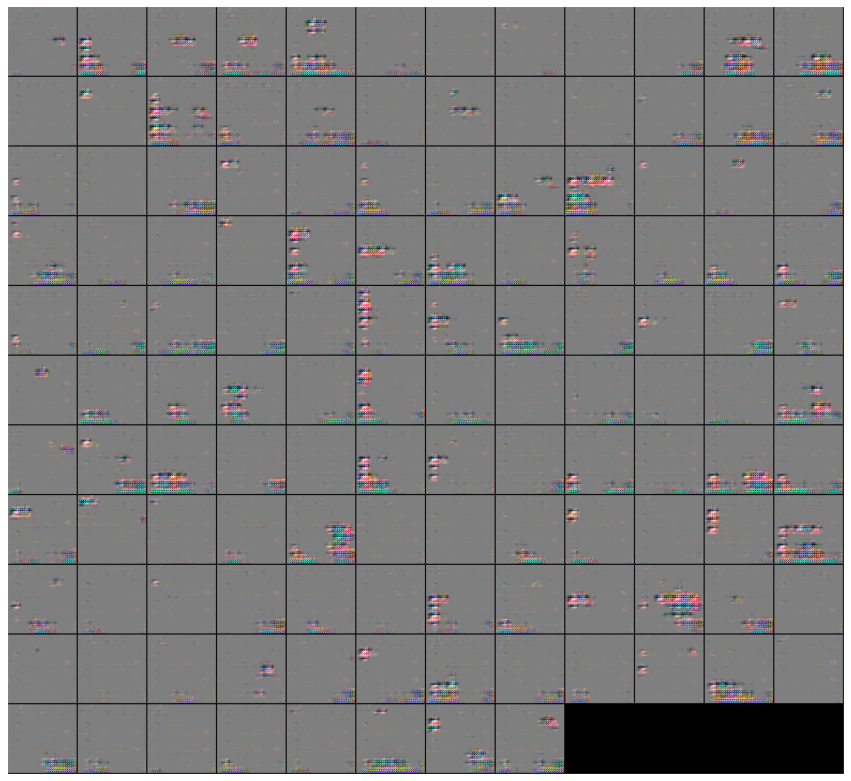

In [ ]:
def show_images(images, n_images):
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach().cpu()), nrow=12).permute(1, 2, 0))

show_images(fake_images, n_images)

Как вам качество получившихся изображений?

Нормально...

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [ ]:
sample_dir = './generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
n_images = len(train_dl.dataset)

for i in range(n_images):
    torch.cuda.empty_cache()
    latent = torch.randn(1, latent_size, 1, 1, device=DEVICE)
    fake_images = model["generator"](latent)
    save_image(denorm(fake_images), os.path.join(sample_dir, f'{i}.png'))

In [ ]:
transform = tfs.Compose(
    [
        tfs.Resize(image_size),
        tfs.CenterCrop(image_size),
        tfs.ToTensor(),
        tfs.Normalize(*stats),
    ])

gen_ds = MyDataset(image_paths=sample_dir, transform=transform, label=0)

train_dir = r'./faces_dataset_small'
train_ds = MyDataset(image_paths=train_dir, transform=transform, label = 1)

all_ds = torch.utils.data.ConcatDataset([gen_ds, train_ds])

dataloader= DataLoader(all_ds, shuffle=True, pin_memory=True, drop_last=True)

In [ ]:
X, Y = [], []
for i in range(n_images):
    x, y = next(iter(dataloader))
    X.append(x.reshape(-1).numpy())
    Y.append(y.numpy())
    # break

X = np.array(X)
Y = np.array(Y)
print(f'X = {X.shape}\t Y = {Y.shape}')

X = (3143, 49152)	 Y = (3143, 1)


In [ ]:
X = X.reshape(n_images, -1)
Y = Y.reshape(n_images, -1)
print(f'X = {X.shape}\t Y = {Y.shape}')
data = [X, Y]

X = (3143, 49152)	 Y = (3143, 1)


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import LeaveOneOut

In [ ]:
# model = KNeighborsClassifier(n_neighbors=1)
loo = LeaveOneOut()
accur = []
i = 0

for train, test in loo.split(X=X, y=Y):
    X_train = X[train]
    y_train = Y[train].ravel()
    x_test = X[test]
    y_test = Y[test].ravel()
    # print(f'X = {X_train.shape}\t Y = {y_train.ravel().shape}')

    model = KNeighborsClassifier(n_neighbors=1)
    model.fit(X_train, y_train)
    
    pred = model.predict(x_test)
    accur.append(pred == y_test)

    i += 1
    print(i, end='\r')

np.mean(accur)

KeyboardInterrupt: 

Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

Идеальная генеративная модель будет иметь accuracy = 0.5, так как сгенерированные данные не будут отличаться от оригиналов и определение истинности будет с вероятностью 1/2

Моя же модель определяет с большой точностью, значит сгенерированные данные сильно отличаются от обучающих

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [ ]:
from sklearn.manifold import TSNE
import pandas as pd


n_components = 2
tsne = TSNE(n_components)
tsne_result = tsne.fit_transform(X)
print(f'after t-SNE, X.shape = {tsne_result.shape}')

c:\Users\Sergei\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Sergei\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


after t-SNE, X.shape = (3143, 2)


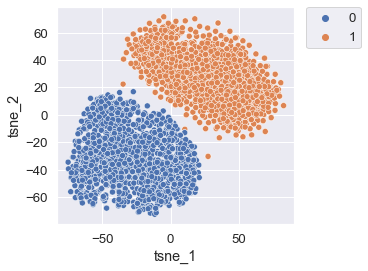

In [ ]:
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 
                               'tsne_2': tsne_result[:,1], 
                               'label': Y.ravel()})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', 
                data=tsne_result_df, ax=ax, palette="deep")
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

Прокомментируйте получившийся результат:

Фиговый результат, что ещё сказать..))0)
Значения четко разделимы даже в двумерном пространстве - значит они сильно отличаются - значит модель плохая..(